# 01 Prepare scenarios

In [1]:
import os
from pathlib import Path

import pandas as pd
import pyam
import dotenv

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
dotenv.load_dotenv()

True

Step 1: Read in and process the SR1.5 data.

In [3]:
df_sr15 = pd.read_excel(
    os.environ['SR15'],
    sheet_name='data'
)

In [4]:
df_sr15_magicc = pyam.IamDataFrame(
    df_sr15[df_sr15['Variable']=='AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED']
)

In [5]:
df_sr15_magicc.load_meta(
    os.environ['SR15_META']
)

[WARNING] 09:46:33 - pyam.core: Ignoring meta indicators for the following scenarios:
                                          model                       scenario
0                               GENeSYS-MOD 1.0                            1.0
1  IEA Energy Technology Perspective Model 2017                           B2DS
2                                     Reference                           CEDS
3                                     Reference  IEA Energy Statistics (r2017)
4                 Shell World Energy Model 2018                            Sky
[INFO] 09:46:33 - pyam.core: Found column 'exclude' in sheet 'meta', moved to attribute `IamDataFrame.exclude`.


In [6]:
df_sr15_magicc.filter(
    category=[
        'Below 1.5C',
        '1.5C low overshoot'
    ],
    inplace=True
)

<Axes: title={'center': 'region: World - variable: AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED'}, xlabel='Year', ylabel='°C'>

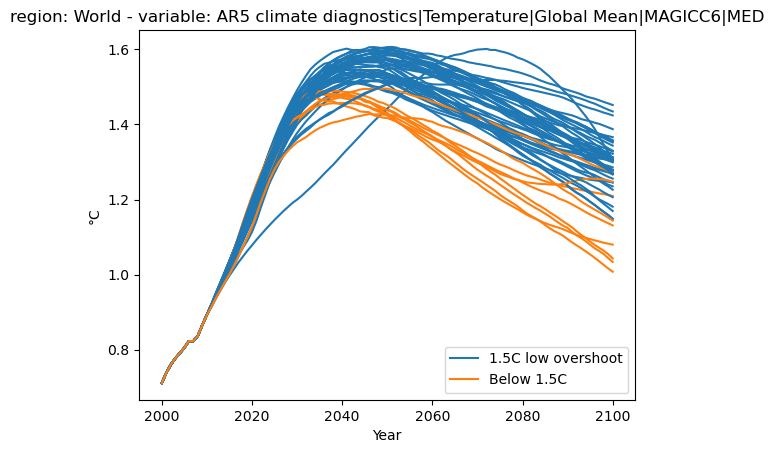

In [7]:
df_sr15_magicc.plot(color='category')

Step 2: Prepare the AR6 scenario data

In [8]:
df_ar6 = pd.read_csv(
    os.environ['AR6']
)

In [9]:
df_ar6_clim_diagnostics= pyam.IamDataFrame(
    df_ar6[df_ar6['Variable'].str.contains('AR6 climate diagnostics')]
)

In [10]:
df_ar6_clim_diagnostics.load_meta(
    os.environ['AR6_META']
)

[WARNING] 09:46:37 - pyam.core: Ignoring meta indicators for the following scenarios:
         model     scenario
0  AIM/CGE 2.1  CO_2Deg2020
1  AIM/CGE 2.1  CO_2Deg2030
2  AIM/CGE 2.1       CO_BAU
3  AIM/CGE 2.1       CO_GPP
4  AIM/CGE 2.1   CO_NDCplus
...


In [11]:
df_ar6_clim_diagnostics_clim = (
    df_ar6_clim_diagnostics
    .filter(
        Category='C1',
        variable='AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile'
    )
)

<Axes: title={'center': 'region: World - variable: AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile'}, xlabel='Year', ylabel='K'>

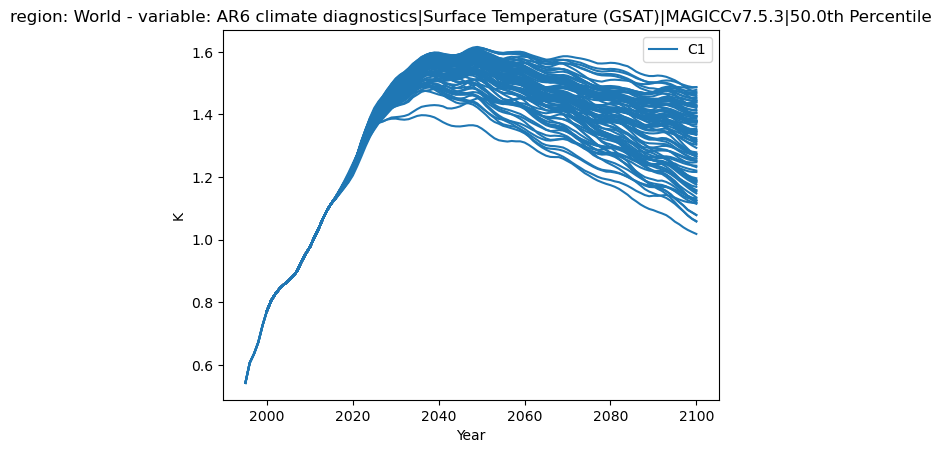

In [12]:
df_ar6_clim_diagnostics_clim.plot(color='Category')

Step 3: process NGFS data

In [13]:
ngfs = pyam.IamDataFrame(
    os.environ['NGFS']
)

[INFO] 09:46:39 - pyam.core: Reading file /Users/gauravganti/Documents/databases/IAM_data.xlsx


In [14]:
ngfs_data = ngfs.filter(
    scenario=[
        'Low demand',
        'Net Zero 2050'
    ],
    variable='AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile'
)

In [15]:
ngfs_data.interpolate(
    time=range(2020,2100),
    inplace=True
)

Step 4: Make a data directory if it does not already exist

In [16]:
if not os.path.exists('data'):
    os.makedirs('data')

In [17]:
df_sr15_magicc.to_excel(
    'data/01_sr15_data.xlsx'
)

In [18]:
df_ar6_clim_diagnostics_clim.to_excel(
    'data/01_ar6_data.xlsx'
)

In [19]:
ngfs_data.to_excel(
    'data/01_ngfs_data.xlsx'
)